# Imports

In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.4.1


In [1]:
!pip install tflocalpattern

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model
import numpy as np

from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from time import time

In [2]:
from collections import Counter
from tflocalpattern.layers import LDP

ModuleNotFoundError: No module named 'tflocalpattern'

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=0.4)
n_samples, h, w = lfw_people.images.shape

#X = lfw_people.data
#n_features = X.shape[1]
n_features = lfw_people.data.shape[1]
# the label to predict is the id of the person
#y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 2370
n_features: 1850
n_classes: 34


# EDA

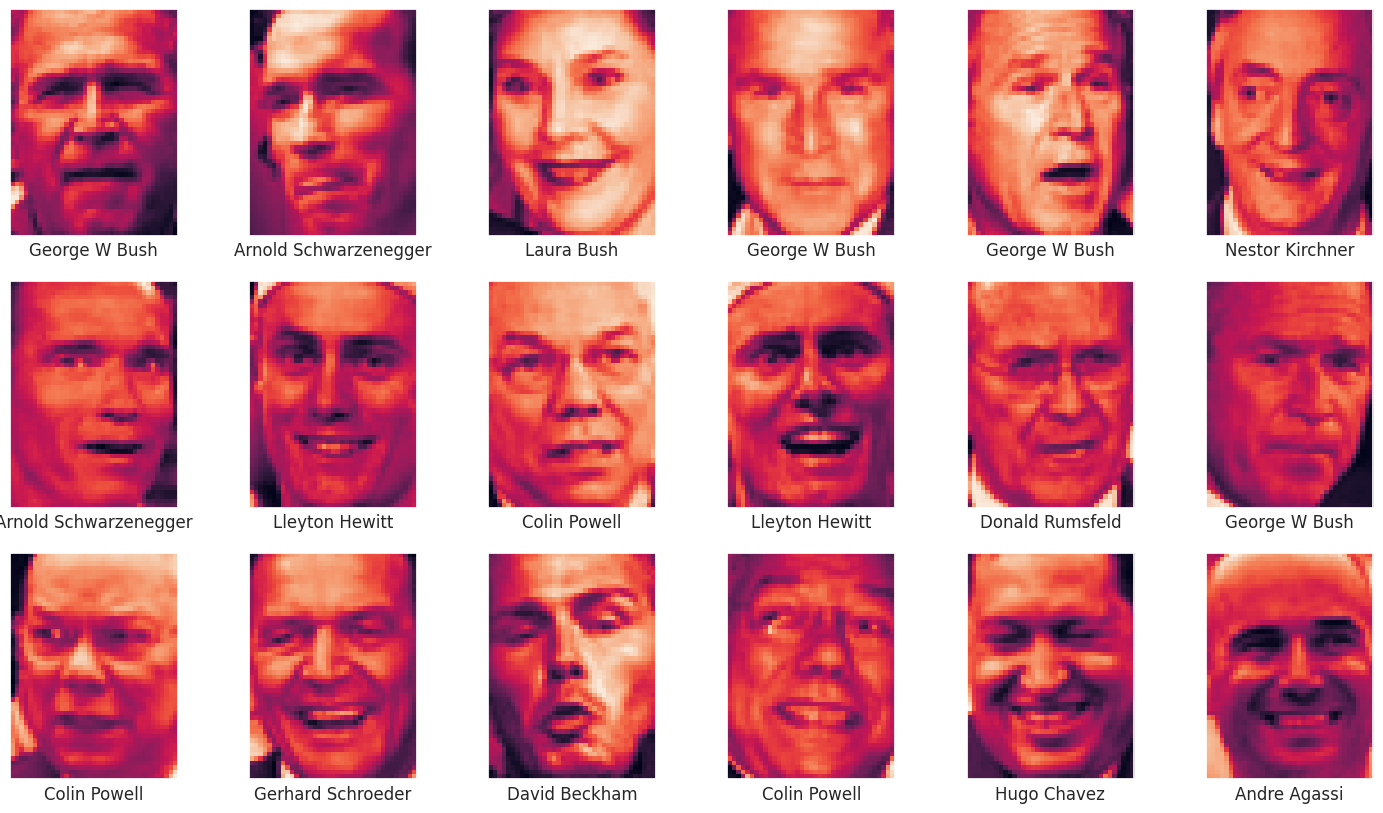

In [3]:
%matplotlib inline
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 6, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(lfw_people.images[i] / 255) # Scale pixel values so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=target_names[lfw_people.target[i]])


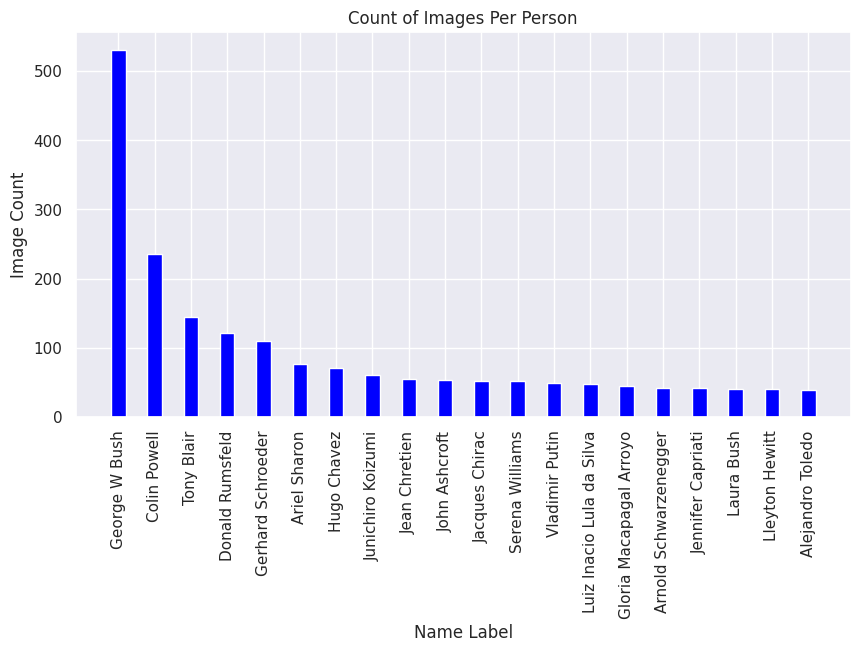

In [4]:
face_names = [target_names[lfw_people.target[i]] for i in range(lfw_people.target.shape[0])]
arr = np.array(np.unique(face_names, return_counts=True)).T
arr = [(a, int(b)) for a,b in arr]
arr = sorted(arr,  key=lambda x: x[1], reverse=True)

fig = plt.figure(figsize = (10, 5))
names = [names for names, count in arr]
count = [count for names, count in arr]

plt.bar(names[:20], count[:20], color ='blue',
        width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Name Label")
plt.ylabel("Image Count")
plt.title("Count of Images Per Person")
plt.show()

In [5]:
# limit each person to only have 10 images in handling imbalanced data
mask = np.zeros(lfw_people.target.shape, dtype=bool)

for target in np.unique(lfw_people.target):
    mask[np.where(lfw_people.target == target)[0][:20]] = 1

X = lfw_people.data[mask]
y = lfw_people.target[mask]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PCA - Eigenfaces

Text(0, 0.5, 'cumulative explained variance')

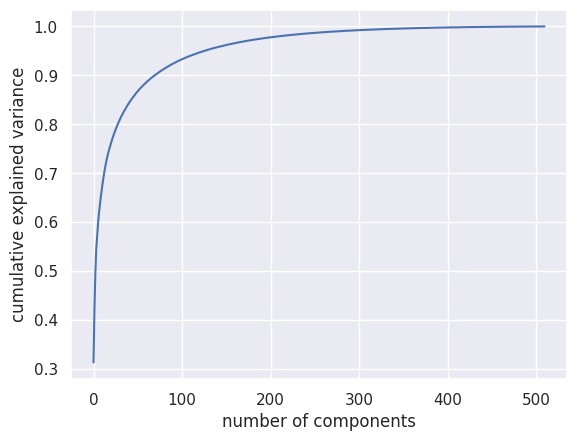

In [8]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [9]:
# 100 components capture arund 95% variance
n_components = 100

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 100 eigenfaces from 510 faces
done in 0.242s


In [10]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.029s


In [11]:
def plot_gallery(images, titles, h, w, n_row=5, n_col=6):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)

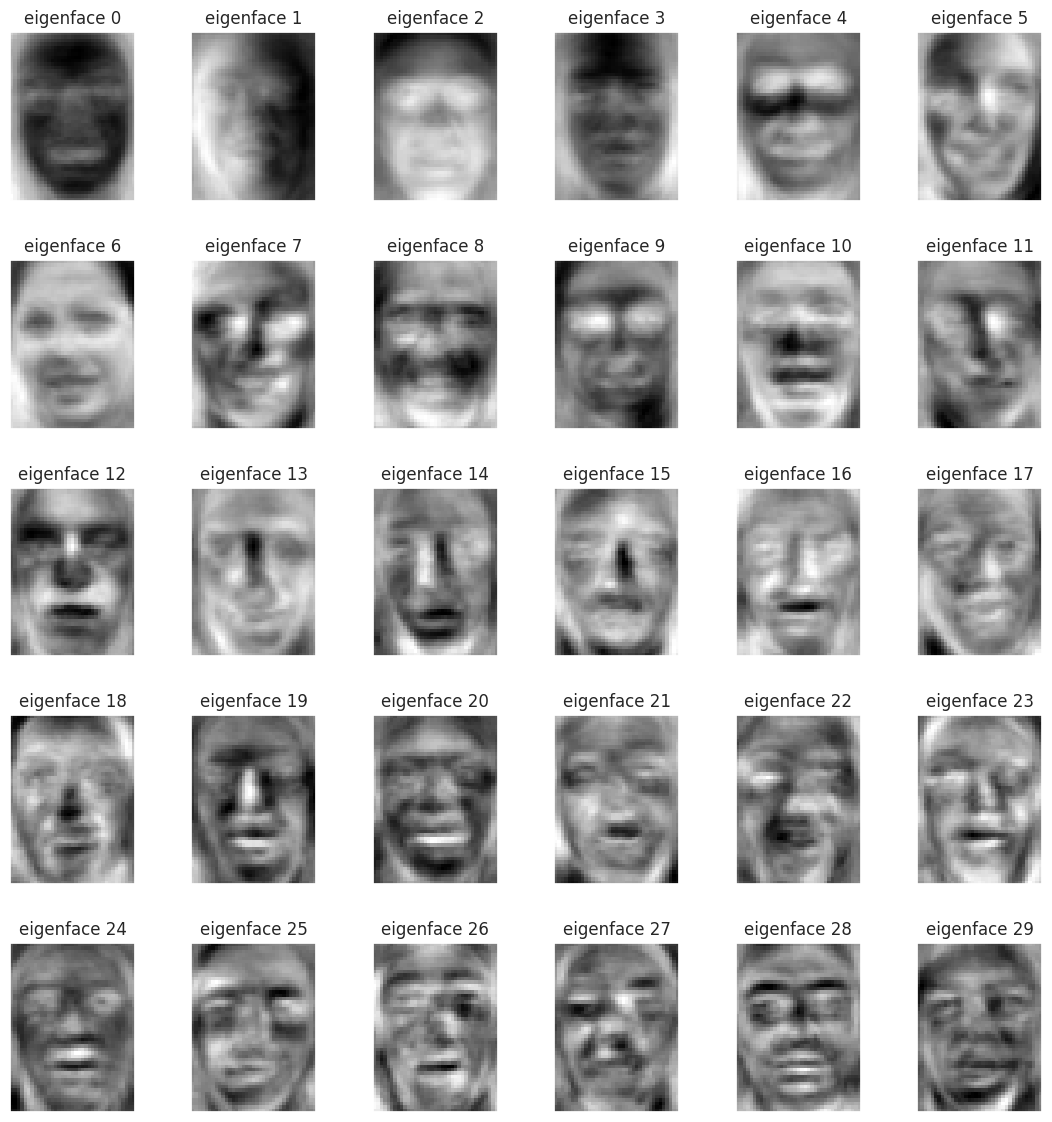

In [12]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# SVM

In [13]:
print("Fitting the SVM classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the SVM classifier to the training set
done in 2.457s
Best estimator found by grid search:
SVC(C=6075.353416475889, class_weight='balanced', gamma=0.0019009251872573827)


In [14]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

Predicting people's names on the test set
done in 0.020s


In [15]:
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

         Alejandro Toledo       0.33      0.60      0.43         5
             Alvaro Uribe       1.00      0.43      0.60         7
             Andre Agassi       1.00      0.50      0.67         6
             Ariel Sharon       0.75      1.00      0.86         3
    Arnold Schwarzenegger       0.22      0.50      0.31         4
             Colin Powell       0.33      0.50      0.40         6
            David Beckham       0.43      0.38      0.40         8
          Donald Rumsfeld       0.25      0.14      0.18         7
            George W Bush       0.50      0.67      0.57         6
        Gerhard Schroeder       0.12      0.50      0.20         2
  Gloria Macapagal Arroyo       0.88      0.88      0.88         8
          Guillermo Coria       0.60      0.50      0.55         6
                Hans Blix       0.00      0.00      0.00         5
              Hugo Chavez       1.00      0.33      0.50     

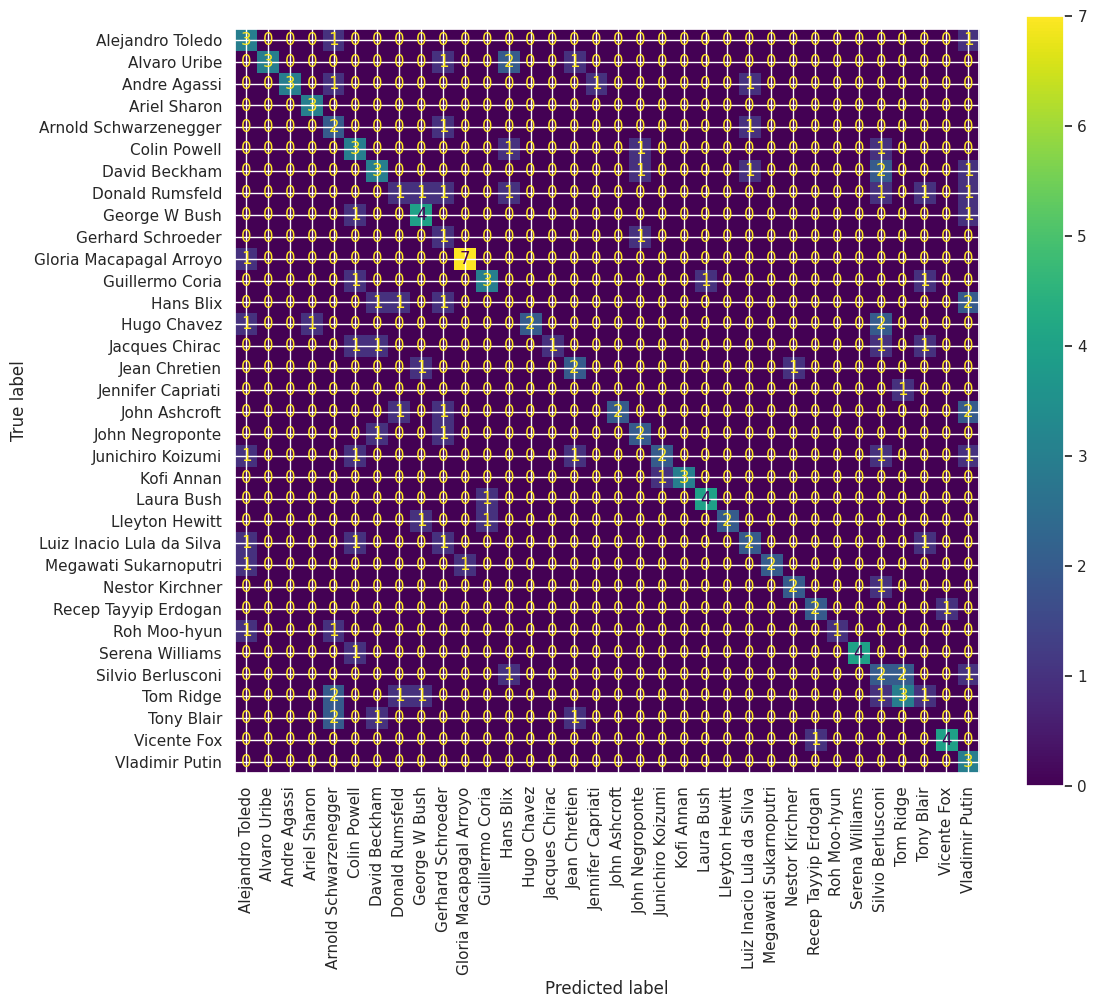

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
cmp = ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical", ax = ax
)
#plt.tight_layout()
#plt.show()

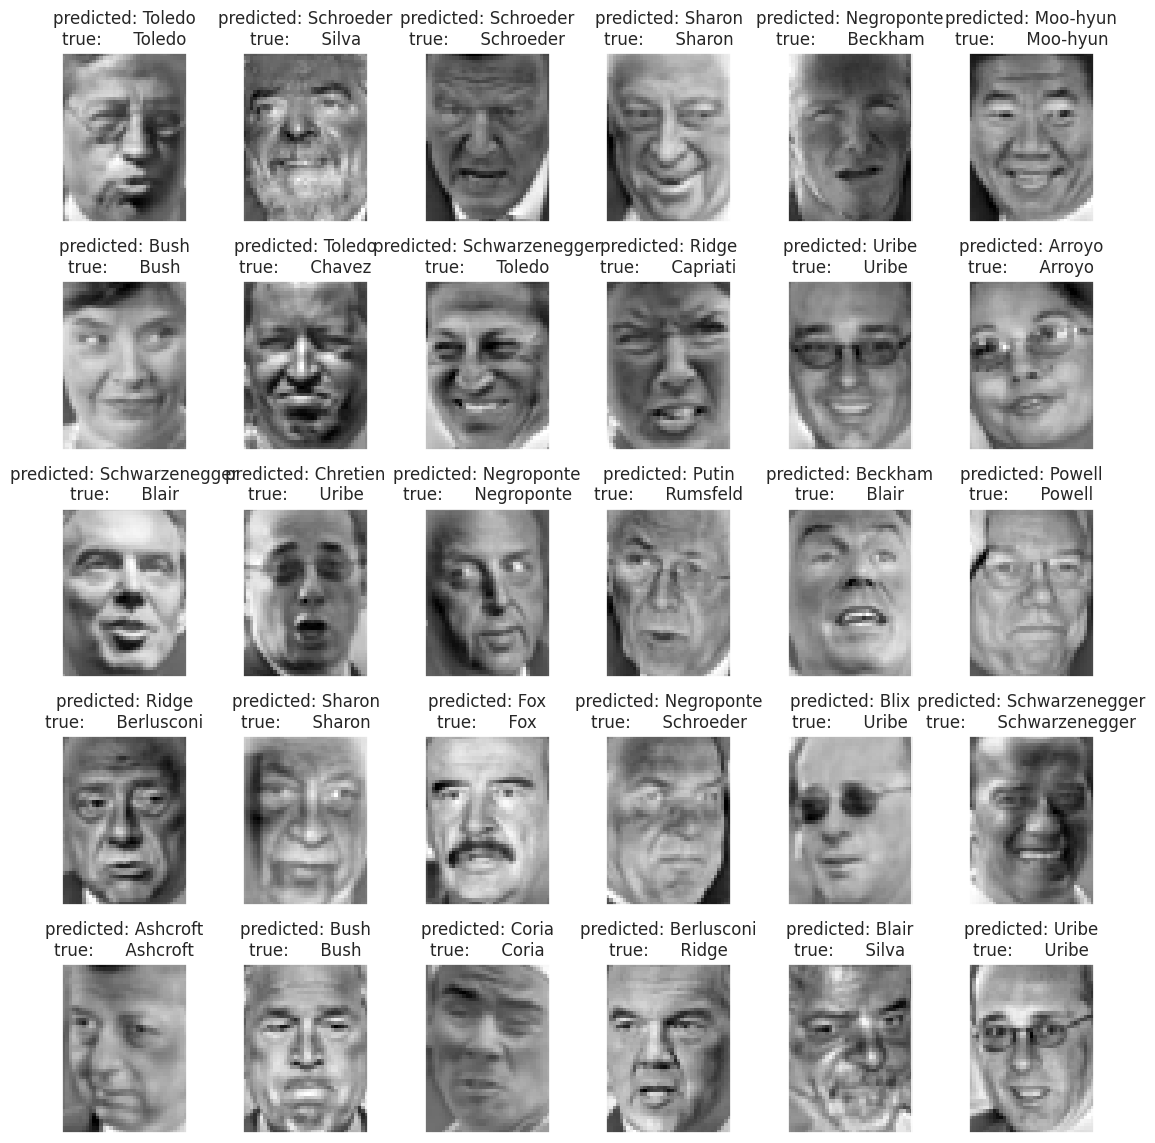

In [17]:
prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

# Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
print("Fitting the Random Forest classifier to the training set")
t0 = time()
rf = RandomForestClassifier()
rf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))

Fitting the Random Forest classifier to the training set
done in 0.874s


In [19]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = rf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

Predicting people's names on the test set
done in 0.015s


In [20]:
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

         Alejandro Toledo       0.00      0.00      0.00         5
             Alvaro Uribe       0.57      0.57      0.57         7
             Andre Agassi       1.00      0.17      0.29         6
             Ariel Sharon       0.50      1.00      0.67         3
    Arnold Schwarzenegger       0.00      0.00      0.00         4
             Colin Powell       0.00      0.00      0.00         6
            David Beckham       0.29      0.25      0.27         8
          Donald Rumsfeld       0.50      0.29      0.36         7
            George W Bush       0.20      0.33      0.25         6
        Gerhard Schroeder       0.00      0.00      0.00         2
  Gloria Macapagal Arroyo       0.75      0.38      0.50         8
          Guillermo Coria       0.50      0.50      0.50         6
                Hans Blix       0.00      0.00      0.00         5
              Hugo Chavez       0.33      0.17      0.22     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.57      0.57      0.57         7
           2       1.00      0.17      0.29         6
           3       0.50      1.00      0.67         3
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         6
           6       0.29      0.25      0.27         8
           7       0.50      0.29      0.36         7
           8       0.20      0.33      0.25         6
           9       0.00      0.00      0.00         2
          10       0.75      0.38      0.50         8
          11       0.50      0.50      0.50         6
          12       0.00      0.00      0.00         5
          13       0.33      0.17      0.22         6
          14       0.50      0.20      0.29         5
          15       0.25      0.25      0.25         4
          16       0.25      1.00      0.40         1
          17       0.67    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


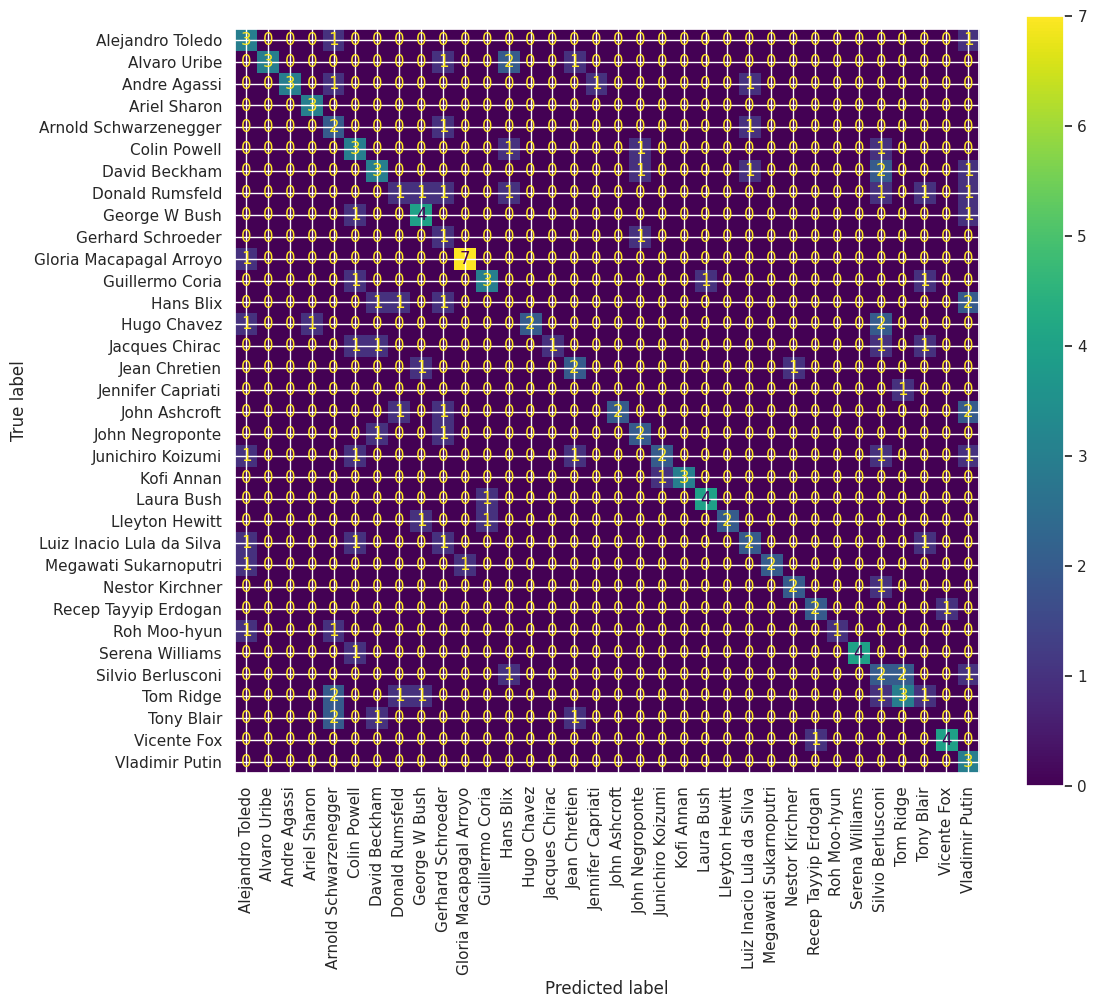

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
cmp = ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical", ax = ax
)

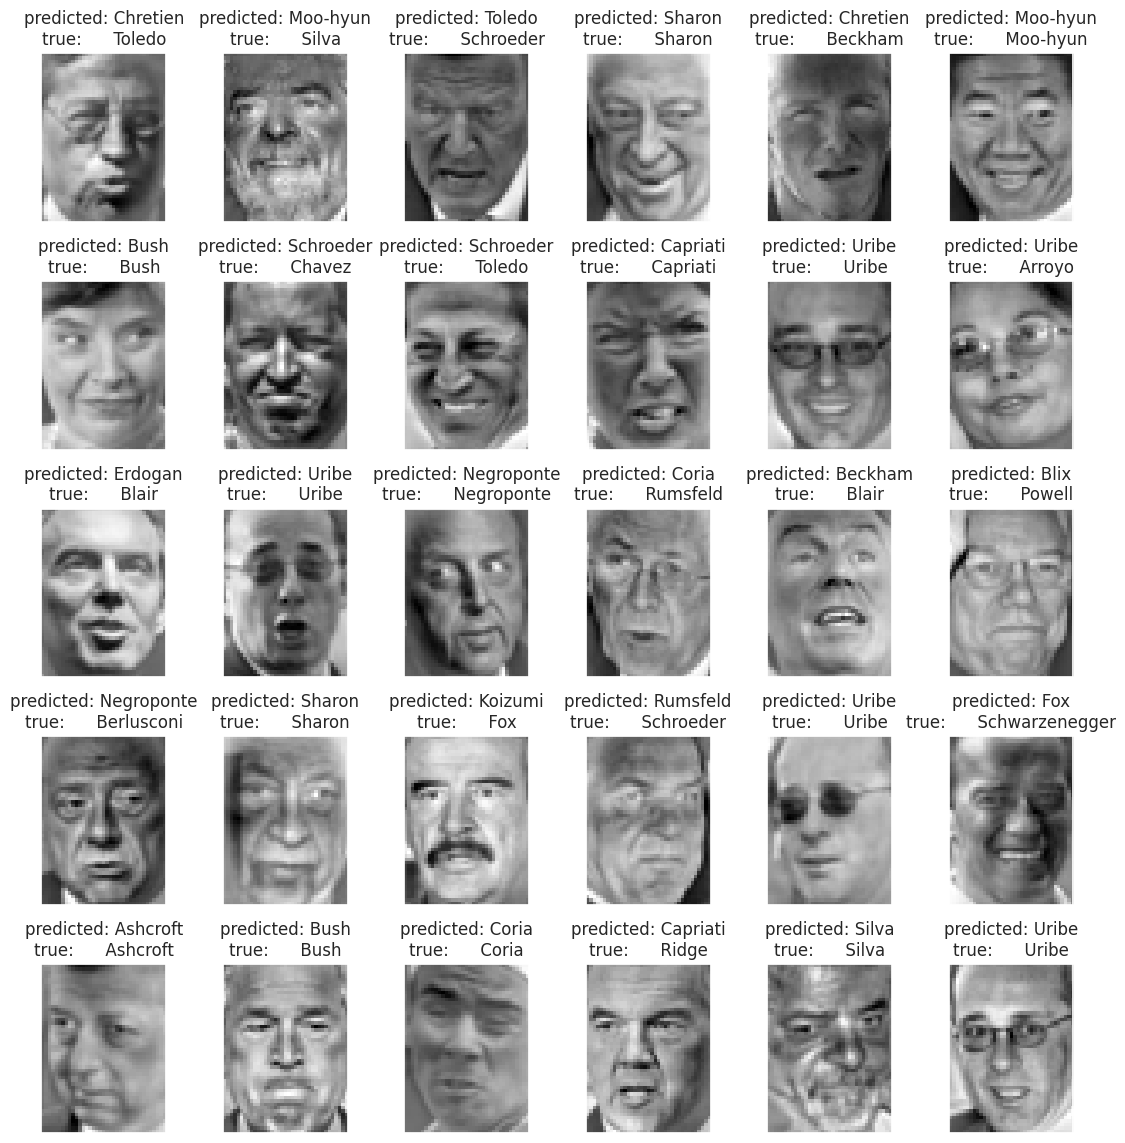

In [23]:
prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

# CNN

In [24]:
X_train.shape

(510, 1850)

In [25]:
faces = fetch_lfw_people(min_faces_per_person=30, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=True)
class_count = len(faces.target_names)

In [26]:
mask = np.zeros(faces.target.shape, dtype=bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:30]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
x_faces.shape

(1020, 128, 128, 3)

In [27]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

face_images = preprocess_input(np.array(x_faces))
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0)

In [31]:
#from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
#datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
#                    width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

34

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(face_images.shape[1:])))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=128)


Epoch 1/20
7/7 [==============================] - 32s 4s/step - loss: 42.9385 - accuracy: 0.0245 - val_loss: 3.5264 - val_accuracy: 0.0294
Epoch 2/20
7/7 [==============================] - 29s 4s/step - loss: 3.5379 - accuracy: 0.0233 - val_loss: 3.5268 - val_accuracy: 0.0294
Epoch 3/20
7/7 [==============================] - 30s 4s/step - loss: 3.5264 - accuracy: 0.0294 - val_loss: 3.5265 - val_accuracy: 0.0294
Epoch 4/20
7/7 [==============================] - 27s 4s/step - loss: 3.5310 - accuracy: 0.0294 - val_loss: 3.5264 - val_accuracy: 0.0294
Epoch 5/20
7/7 [==============================] - 29s 4s/step - loss: 3.5264 - accuracy: 0.0294 - val_loss: 3.5264 - val_accuracy: 0.0294
Epoch 6/20
7/7 [==============================] - 27s 4s/step - loss: 3.5264 - accuracy: 0.0294 - val_loss: 3.5264 - val_accuracy: 0.0294
Epoch 7/20
7/7 [==============================] - 28s 4s/step - loss: 3.5264 - accuracy: 0.0294 - val_loss: 3.5264 - val_accuracy: 0.0294
Epoch 8/20
7/7 [=================

[]

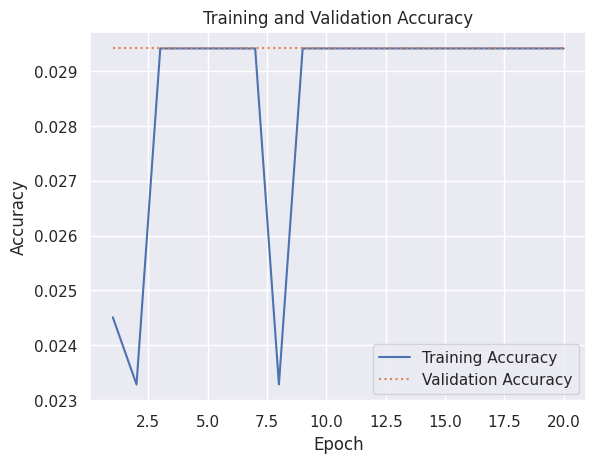

In [33]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

# Transfer Learning - ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False
from keras.models import Sequential
from keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=20)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/20
7/7 [==============================] - 220s 31s/step - loss: 8.6939 - accuracy: 0.0282 - val_loss: 3.5254 - val_accuracy: 0.0294
Epoch 2/20
7/7 [==============================] - 245s 36s/step - loss: 3.5513 - accuracy: 0.0233 - val_loss: 3.5264 - val_accuracy: 0.0294
Epoch 3/20
7/7 [==============================] - 267s 40s/step - loss: 3.5264 - accuracy: 0.0208 - val_loss: 3.5264 - val_accuracy: 0.0294
Epoch 4/20
7/7 [==============================] - 212s 31s/step - loss: 3.5288 - accuracy: 0.0294 - val_loss: 3.5264 - val_accuracy: 0.0294
Epoch 5/20
7/7 [==============================] - 203s 30s/step - loss: 3.5264 - accuracy: 0.0294 - val_loss: 3.5264 - val_accuracy: 0.0294
Epoch 6/20
7/7 [==============================] - 201s 29s/step - loss: 3.5264 - accuracy: 0.0294 - val_loss: 3.5264 - val_accuracy: 0.0294
Epoch 7/20
7/7 [==============================] - 213s 31s/step - loss: 3.5264 - accuracy: 0.02

[]

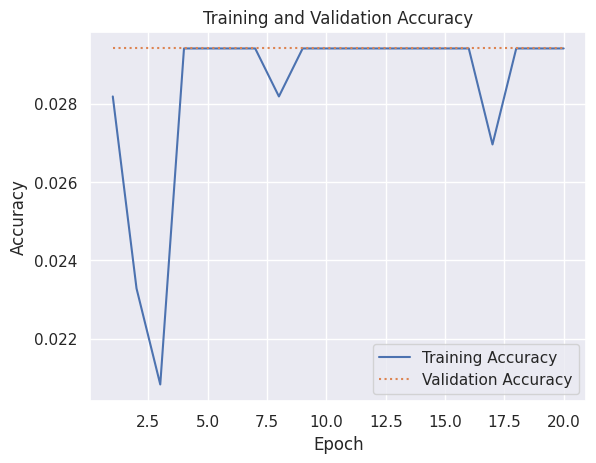

In [37]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
# omit this model
from keras_vggface.vggface import VGGFace

base_model = VGGFace(model='resnet50', include_top=False)
base_model.trainable = False

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=50)